# **Predicting NBA Game Outcomes with Machine Learning based on Team Performance Metrics**

Authors: Jesse Neiman, Ivan Camps

# Part 1: Introduction and Background



Throughout this past semester we had the opportunity to explore a variety of machine learning processes and their various use cases in predictive analysis using large data sets. When deciding on our motivation with respect to this project our group decided to couple our interest in predicting sports outcomes with the subject matter learned throughout this course. At first, we considered the possibility of predicting the expected values of player strategies given their performance in last seasons. However, our trajectory quickly changed on the night before the proposal for this project was due when Iván and I were settling down to watch the Bulls, who at the time were off to an unexpectedly hot start, play the Laker super team that was not living up to expectations. After discussing which team would be best to bet on, we were wishing that we had more insight beyond that of other analysts. It was not long before we decided to pivot and plan to make our machine learning model a project that we could use not only to demonstrate what we have learned throughout the semester, but a project that would hopefully aid us in our sports betting endeavors in the future. The steps that we took in completing this project are as follows:

1. **Selecting our dataset:** In selecting our data set, we wanted to make sure that we had a sufficient sample size of past games that contained a prolific assortment of game-specific data which we could then use to construct more complex feature variables. The data set that we found to best fit our needs for this project was published a month ago on Kaggle by Nathan Lauga. The game data is current and appropriately organized to complement our next steps and overall objective.
1. **Cleaning our dataset:** We decided on the appropriate metrics that would best suit our models and which we could remove. The metrics we decided on were primarily pertinent to the overall team performance in percentage of field goal, free throw, and three point shots made by the home and away teams respectively.  
1. **Feature Engineering:** After our data was cleaned appropriately, we used the relevant features given to create moving averages for each over a 10-game window to best represent the state of the team at the time rather than extrapolating game outcomes using outdated team data from years past. We are focused on the trends in team shot performance, not historical outcomes. 
4. **Data exploration:** Our assumptions alone on the suspected improved accuracy of our features would not suffice. We must explore whether there is underlying bias or cases of multi-collinearity among our features before we move on to our predictions.
5. **Model building:** After deeming our data to be acceptable, we moved forward in applying the following machine learning methods: . The question is, which will prove to be the most accurate?

Let’s dive into each of these steps a bit further…


# Part 2: Data Loading and Cleaning

## 2.1. Initialization and imports

Typical Package Installation:

In [3]:
# Sklearn and Pandas Setup
import pandas as pd
if pd.__version__ != '1.1.5':
  !pip install pandas==1.1.5
import numpy as np 
import json
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from datetime import datetime
import glob
import seaborn as sns
import re
import os
import io 
import requests

In [4]:
import warnings
warnings.filterwarnings("ignore")

## 2.2. Loading Data

First, we import the GoogleDriveDownloader package so that we, or anyone with this notebook, can upload the CSV files that we saved on our local drives. The data sets that we chose to include contain game outcomes and scoring metrics for both the home and away team with respect to a common “Game ID”, team ranking which keeps a running record of each team’s home, away and overall record during each season, and finally a “teams” data set which we use to better interpret game outcomes. 

In [5]:
outcomes_url = 'https://raw.githubusercontent.com/ivancamps/nba-prediction-model/main/Game_outcome.csv'
outcomes_dl = requests.get(outcomes_url).content

ranking_url = 'https://raw.githubusercontent.com/ivancamps/nba-prediction-model/main/ranking.csv'
ranking_dl = requests.get(ranking_url).content

teams_url = 'https://raw.githubusercontent.com/ivancamps/nba-prediction-model/main/teams.csv'
teams_dl = requests.get(teams_url).content

In [6]:
game_outcome =  pd.read_csv(io.StringIO(outcomes_dl.decode('utf-8')))
ranking = pd.read_csv(io.StringIO(ranking_dl.decode('utf-8')))
teams = pd.read_csv(io.StringIO(teams_dl.decode('utf-8')))

After we upload each data set, we explore the data type of each variable and give ourselves an visualize the first few rows to make sure that the datasets have been uploaded correctly. 

In [7]:
# Explore game_outcome dataset 
game_outcome.dtypes

GAME_DATE_EST        object
GAME_ID               int64
GAME_STATUS_TEXT     object
HOME_TEAM_ID          int64
VISITOR_TEAM_ID       int64
SEASON                int64
TEAM_ID_home          int64
PTS_home            float64
FG_PCT_home         float64
FT_PCT_home         float64
FG3_PCT_home        float64
AST_home            float64
REB_home            float64
TEAM_ID_away          int64
PTS_away            float64
FG_PCT_away         float64
FT_PCT_away         float64
FG3_PCT_away        float64
AST_away            float64
REB_away            float64
HOME_TEAM_WINS        int64
dtype: object

In [8]:
game_outcome.head(5)

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,...,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
0,2021-11-17,22100213,Final,1610612766,1610612764,2021,1610612766,97.0,0.438,0.500,...,30.0,59.0,1610612764,87.0,0.367,0.813,0.190,23.0,48.0,1
1,2021-11-17,22100214,Final,1610612765,1610612754,2021,1610612765,97.0,0.425,0.750,...,16.0,42.0,1610612754,89.0,0.418,0.737,0.243,14.0,43.0,1
2,2021-11-17,22100215,Final,1610612737,1610612738,2021,1610612737,110.0,0.506,0.833,...,28.0,40.0,1610612738,99.0,0.440,0.824,0.268,24.0,42.0,1
3,2021-11-17,22100216,Final,1610612751,1610612739,2021,1610612751,109.0,0.458,0.840,...,29.0,47.0,1610612739,99.0,0.393,0.857,0.250,20.0,50.0,1
4,2021-11-17,22100217,Final,1610612748,1610612740,2021,1610612748,113.0,0.483,0.824,...,29.0,39.0,1610612740,98.0,0.440,0.786,0.286,18.0,38.0,1


In [9]:
# Explore ranking dataset 
ranking.dtypes

TEAM_ID            int64
LEAGUE_ID          int64
SEASON_ID          int64
STANDINGSDATE     object
CONFERENCE        object
TEAM              object
G                  int64
W                  int64
L                  int64
W_PCT            float64
HOME_RECORD       object
ROAD_RECORD       object
RETURNTOPLAY     float64
dtype: object

In [10]:
ranking.head(5)

,TEAM_ID,LEAGUE_ID,SEASON_ID,STANDINGSDATE,CONFERENCE,TEAM,G,W,L,W_PCT,HOME_RECORD,ROAD_RECORD,RETURNTOPLAY
0,1610612744,0,22021,2021-11-17,West,Golden State,14,12,2,0.857,8-1,4-1,NaN
1,1610612756,0,22021,2021-11-17,West,Phoenix,14,11,3,0.786,6-2,5-1,NaN
2,1610612742,0,22021,2021-11-17,West,Dallas,14,9,5,0.643,6-1,3-4,NaN
3,1610612743,0,22021,2021-11-17,West,Denver,14,9,5,0.643,7-1,2-4,NaN
4,1610612746,0,22021,2021-11-17,West,LA Clippers,14,9,5,0.643,7-3,2-2,NaN


In [11]:
teams.dtypes

LEAGUE_ID               int64
TEAM_ID                 int64
MIN_YEAR                int64
MAX_YEAR                int64
ABBREVIATION           object
NICKNAME               object
YEARFOUNDED             int64
CITY                   object
ARENA                  object
ARENACAPACITY         float64
OWNER                  object
GENERALMANAGER         object
HEADCOACH              object
DLEAGUEAFFILIATION     object
dtype: object

In [12]:
teams.head(5)

,LEAGUE_ID,TEAM_ID,MIN_YEAR,MAX_YEAR,ABBREVIATION,NICKNAME,YEARFOUNDED,CITY,ARENA,ARENACAPACITY,OWNER,GENERALMANAGER,HEADCOACH,DLEAGUEAFFILIATION
0,0,1610612737,1949,2019,ATL,Hawks,1949,Atlanta,State Farm Arena,18729.0,Tony Ressler,Travis Schlenk,Lloyd Pierce,Erie Bayhawks
1,0,1610612738,1946,2019,BOS,Celtics,1946,Boston,TD Garden,18624.0,Wyc Grousbeck,Danny Ainge,Brad Stevens,Maine Red Claws
2,0,1610612740,2002,2019,NOP,Pelicans,2002,New Orleans,Smoothie King Center,NaN,Tom Benson,Trajan Langdon,Alvin Gentry,No Affiliate
3,0,1610612741,1966,2019,CHI,Bulls,1966,Chicago,United Center,21711.0,Jerry Reinsdorf,Gar Forman,Jim Boylen,Windy City Bulls
4,0,1610612742,1980,2019,DAL,Mavericks,1980,Dallas,American Airlines Center,19200.0,Mark Cuban,Donnie Nelson,Rick Carlisle,Texas Legends




## 2.3. Cleaning and Wrangling Loaded Data

After examining our data and considering the viability of each variable’s function in our exploration, we decided to drop Game Status, Home Team ID and Visitor Team ID from the Game Outcome dataset and League ID, Season ID, Conference and Return to Play from the ranking dataset.

In [13]:
# Drop irrelevant columns from game_outcome dataset (GAME_STATUS_TEXT, HOME_TEAM_ID, VISITOR_TEAM_ID)
game_outcome = game_outcome.drop(['GAME_STATUS_TEXT', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID'], axis = 1)

# Drop irrelevant columns from ranking dataset (LEAGUE_ID, SEASON_ID, CONFERENCE, RETURNTOPLAY)
ranking = ranking.drop(['LEAGUE_ID', 'SEASON_ID', 'CONFERENCE', 'RETURNTOPLAY'], axis = 1)

We then convert the home and away records to percentages as they will be more interpretable than their previous object data type and drop all the record input columns and solely use the now constructed home and away win percentage columns going forward. 

In [14]:
# Add home win percentage and away win percentage to ranking dataset and get rid of home record and away record columns

# Divide home record column into wins and losses
ranking[['HOME_WINS', 'HOME_LOSES']] = ranking['HOME_RECORD'].str.split('-', 1, expand = True).astype('int64')

# Divide away record column into wins and losses
ranking[['AWAY_WINS', 'AWAY_LOSES']] = ranking['ROAD_RECORD'].str.split('-', 1, expand = True).astype('int64')

# calculate home and away win percentages
ranking['H_W_PCT'] = ranking['HOME_WINS'] / (ranking['HOME_WINS'] + ranking['HOME_LOSES'])
ranking['A_W_PCT'] = ranking['AWAY_WINS'] / (ranking['AWAY_WINS'] + ranking['AWAY_LOSES'])

# drop record columns (now irrelevant), intermediate columns created, and useless columns moving forward
ranking = ranking.drop(['G', 'W', 'L', 'HOME_RECORD', 'ROAD_RECORD', 'HOME_WINS', 'HOME_LOSES', 'AWAY_WINS', 'AWAY_LOSES'], axis = 1)

ranking.head(5)

,TEAM_ID,STANDINGSDATE,TEAM,W_PCT,H_W_PCT,A_W_PCT
0,1610612744,2021-11-17,Golden State,0.857,0.888889,0.800000
1,1610612756,2021-11-17,Phoenix,0.786,0.750000,0.833333
2,1610612742,2021-11-17,Dallas,0.643,0.857143,0.428571
3,1610612743,2021-11-17,Denver,0.643,0.875000,0.333333
4,1610612746,2021-11-17,LA Clippers,0.643,0.700000,0.500000


By joining these newly constructed win and loss percentages to the Team Game Stats data frame we effectively consolidated our inputs. Adding suffixes, dropping duplicate columns and removing null values ensures that our dataset can be interpreted and used with ease. 

In [15]:
# Join ranking and game_outcome datasets on TEAM_ID and STANDINGSDATE 
# to obtain a combined dataset with updated season stats for home and away teams after each game

# First, add home team season stats
team_game_stats = game_outcome.merge(ranking, how = 'left', left_on = ['TEAM_ID_home', 'GAME_DATE_EST'], right_on = ['TEAM_ID', 'STANDINGSDATE'])

# add _home suffix to new columns to distinguish from away team
team_game_stats.rename(columns = {'TEAM' : 'TEAM_home', 'W_PCT' : 'W_PCT_home', 'H_W_PCT' : 'H_W_PCT_home', 'A_W_PCT' : 'A_W_PCT_home'}, inplace = True)

# drop duplicate columns before joining again
team_game_stats = team_game_stats.drop(['STANDINGSDATE', 'TEAM_ID'], axis = 1)  

# repeat process to add away team season stats to dataset
team_game_stats = team_game_stats.merge(ranking, how = 'left', left_on = ['TEAM_ID_away', 'GAME_DATE_EST'], right_on = ['TEAM_ID', 'STANDINGSDATE'])

team_game_stats.rename(columns = {'TEAM' : 'TEAM_away', 'W_PCT' : 'W_PCT_away', 'H_W_PCT' : 'H_W_PCT_away', 'A_W_PCT' : 'A_W_PCT_away'}, inplace = True)

# drop duplicate columns again after last join
team_game_stats = team_game_stats.drop(['STANDINGSDATE', 'TEAM_ID'], axis = 1) 

# move HOME_TEAM_WINS column (our label) to the end of dataset for easier visualization 
team_game_stats['HOME_TEAM_WIN'] = team_game_stats['HOME_TEAM_WINS']
team_game_stats = team_game_stats.drop(['HOME_TEAM_WINS'], axis = 1)

In [16]:
# Drop games with NaN values
team_game_stats.dropna(inplace = True)

In [17]:
# Check combined dataset
team_game_stats.head(5)

,GAME_DATE_EST,GAME_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,...,REB_away,TEAM_home,W_PCT_home,H_W_PCT_home,A_W_PCT_home,TEAM_away,W_PCT_away,H_W_PCT_away,A_W_PCT_away,HOME_TEAM_WIN
0,2021-11-17,22100213,2021,1610612766,97.0,0.438,0.500,0.313,30.0,59.0,...,48.0,Charlotte,0.563,0.714286,0.444444,Washington,0.714,0.857143,0.571429,1
1,2021-11-17,22100214,2021,1610612765,97.0,0.425,0.750,0.286,16.0,42.0,...,43.0,Detroit,0.286,0.285714,0.285714,Indiana,0.375,0.666667,0.200000,1
2,2021-11-17,22100215,2021,1610612737,110.0,0.506,0.833,0.351,28.0,40.0,...,42.0,Atlanta,0.438,0.857143,0.111111,Boston,0.467,0.400000,0.500000,1
3,2021-11-17,22100216,2021,1610612751,109.0,0.458,0.840,0.375,29.0,47.0,...,50.0,Brooklyn,0.688,0.625000,0.750000,Cleveland,0.563,0.571429,0.555556,1
4,2021-11-17,22100217,2021,1610612748,113.0,0.483,0.824,0.375,29.0,39.0,...,38.0,Miami,0.667,0.833333,0.555556,New Orleans,0.125,0.142857,0.111111,1


## 2.4. Computing Team Performance Over the Past 10 Games

After an intial failed attempt to efficiently compute the moving averages, we were able to discover a way to reach the same goal by expending less memory in the process. Instead of doing the repeated splits and merges within the "for" loop, we decided to first make an array of dataframes where each data frame contains all games for a given team. After doing so, we created a new function that computes a 10-game moving average of the columns of interest that have been inputed and returning a copy of the dataset with the average of each stat in the last 10 games leading up to the current one

In [18]:
# In this step, we compute 10 game moving averages for all the stats in the dataframe to reflect recent team performance
# For each game, we will append to the dataset columns with the average of each stat in the last 10 games leading up to the current one

# Make an array of dataframes where each dataframe contains all games for a given team
team_list = teams['TEAM_ID'].tolist()

df_list = {}

col_list = ['GAME_DATE_EST', 'GAME_ID', 'TEAM_ID', 'PTS', 'FG_PCT', 'FT_PCT', 'FG3_PCT', 'AST', 'REB', 'W_PCT', 'H_W_PCT', 'A_W_PCT']
col_list_home = ['GAME_DATE_EST', 'GAME_ID', 'TEAM_ID_home', 'PTS_home', 'FG_PCT_home', 'FT_PCT_home', 'FG3_PCT_home', 'AST_home', 
                 'REB_home', 'W_PCT_home', 'H_W_PCT_home', 'A_W_PCT_home']
col_list_away = ['GAME_DATE_EST', 'GAME_ID', 'TEAM_ID_away', 'PTS_away', 'FG_PCT_away', 'FT_PCT_away', 'FG3_PCT_away', 'AST_away',
                 'REB_away', 'W_PCT_away', 'H_W_PCT_away', 'A_W_PCT_away']

count = 0
for team in team_list: 
  df_home = pd.DataFrame()
  df_away = pd.DataFrame()

  df_home[col_list] = team_game_stats[team_game_stats['TEAM_ID_home'] == team][col_list_home]
  df_away[col_list] = team_game_stats[team_game_stats['TEAM_ID_away'] == team][col_list_away]

  df_list[count] = pd.concat([df_home, df_away], ignore_index=True)
  df_list[count] = df_list[count].sort_values(by = ['GAME_DATE_EST'], ascending = False)

  count += 1


This function will now compute a 10 game moving average of the stats (columns) inputed (up to the date of each game) and returns a copy of the dataset with the new moving average columns appended.

In [19]:
#
# input: cols (the columns to compute a 10 game moving average of)
# output: copy of team_game_stats with new _MA10 columns appended
#
def append_moving_average(cols):

  # compute moving averages of the inputed columns and append to each df (team) in the list
  for i in range(len(df_list)):
    for col in cols:
      df_list[i]['' + col + '_MA10'] = df_list[i][col].transform(lambda x: x[::-1].rolling(10, min_periods = 1).mean())

  return df_list

After definining the function, we call it on every dataframe of our df_list to compute the moving averages of all the stats for each team game. We then drop the original columns and keep the 10-game moving averages of these stats as our desired features. Once this is done for every team, we concatenate all the dataframe in the df_list to obtain a dataset containing all games of every team.

Then, we proceed to merge this dataframe with a copy of the original team_game_stats dataset but keeping only the columns that identify each game, date, and the home and away teams, as well as our feature variable. The merge is done in two steps, first merging the MA10 stats for the home team and then merging the MA10 stats for the away team. 

In [20]:
# Compute moving average columns for all stats for each team's dataset in the list and drop individual game stats
stat_cols = ['PTS', 'FG_PCT', 'FT_PCT', 'FG3_PCT', 'AST', 'REB', 'W_PCT', 'H_W_PCT', 'A_W_PCT']

df_list = append_moving_average(stat_cols)

for i in range(len(df_list)):
  df_list[i] = df_list[i].drop(stat_cols, axis = 1)


# Concatenate the individual datasets for each team with the new moving averages 
concat_team_dfs = pd.concat(df_list)

# Create new dataset to append the moving average columns for home and away teams
final_game_stats_ma = team_game_stats[['GAME_DATE_EST',	'GAME_ID', 'SEASON', 'TEAM_ID_home', 'TEAM_home', 'TEAM_ID_away', 'TEAM_away', 'HOME_TEAM_WIN']]

# Merge concatenated datasets on home and away team ids to get stat moving averages home and away
final_game_stats_ma = final_game_stats_ma.merge(concat_team_dfs, how = 'left', left_on = ['GAME_ID', 'TEAM_ID_home'], right_on = ['GAME_ID', 'TEAM_ID'])
final_game_stats_ma = final_game_stats_ma.drop(['GAME_DATE_EST_y', 'TEAM_ID'], axis = 1)

final_game_stats_ma = final_game_stats_ma.merge(concat_team_dfs, how = 'left', left_on = ['GAME_ID', 'TEAM_ID_away'], right_on = ['GAME_ID', 'TEAM_ID'],
                                                suffixes = ('_home', '_away'))
final_game_stats_ma = final_game_stats_ma.drop(['GAME_DATE_EST', 'TEAM_ID'], axis = 1)
final_game_stats_ma = final_game_stats_ma.rename(columns = {'GAME_DATE_EST_x' : 'GAME_DATE_EST'})

Once this is done, we can take a look at our final dataset, which will be used for exploration and modeling. 

In [21]:
final_game_stats_ma

,GAME_DATE_EST,GAME_ID,SEASON,TEAM_ID_home,TEAM_home,TEAM_ID_away,TEAM_away,HOME_TEAM_WIN,PTS_MA10_home,FG_PCT_MA10_home,...,A_W_PCT_MA10_home,PTS_MA10_away,FG_PCT_MA10_away,FT_PCT_MA10_away,FG3_PCT_MA10_away,AST_MA10_away,REB_MA10_away,W_PCT_MA10_away,H_W_PCT_MA10_away,A_W_PCT_MA10_away
0,2021-11-17,22100213,2021,1610612766,Charlotte,1610612764,Washington,1,109.1,0.4418,...,0.518135,105.7,0.4580,0.7862,0.3297,24.9,47.5,0.7299,0.876429,0.583810
1,2021-11-17,22100214,2021,1610612765,Detroit,1610612754,Indiana,1,99.9,0.4088,...,0.122381,103.6,0.4687,0.7129,0.3408,23.3,44.7,0.3312,0.583333,0.123175
2,2021-11-17,22100215,2021,1610612737,Atlanta,1610612738,Boston,1,110.7,0.4605,...,0.152897,102.9,0.4414,0.7932,0.2994,21.3,45.6,0.4222,0.185000,0.553651
3,2021-11-17,22100216,2021,1610612751,Brooklyn,1610612739,Cleveland,1,111.2,0.4849,...,0.664762,101.4,0.4457,0.7831,0.3559,22.7,43.7,0.5725,0.590952,0.565198
4,2021-11-17,22100217,2021,1610612748,Miami,1610612740,New Orleans,1,109.9,0.4675,...,0.605635,101.5,0.4226,0.8341,0.3490,24.2,42.0,0.1131,0.042857,0.175754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24265,2014-10-11,11400037,2014,1610612749,Milwaukee,1610612741,Chicago,0,97.6,0.4643,...,0.114844,93.0,0.4323,0.7740,0.3228,22.1,42.1,0.5619,0.590976,0.516163
24266,2014-10-10,11400031,2014,1610612761,Toronto,1610612738,Boston,1,98.7,0.4527,...,0.429268,101.8,0.4560,0.7955,0.3578,23.8,38.8,0.3413,0.453356,0.193946
24267,2014-10-10,11400029,2014,1610612750,Minnesota,1610612755,Philadelphia,1,109.4,0.4610,...,0.364797,103.7,0.4849,0.7182,0.3257,22.2,37.3,0.2307,0.308619,0.185649
24268,2014-10-09,11400024,2014,1610612757,Portland,1610612762,Utah,0,101.8,0.4358,...,0.504878,100.6,0.4638,0.7190,0.2997,22.4,43.0,0.3759,0.465492,0.286648


From this point onward, we will exclusively use our newly constructed feature varirables in our analysis.

# Part 3: Exploratory Data Analysis

The first step that we took in our exploration was constructing a correlation heat map between our feature inputs. In the matrix, it is apparent that the level of correlation between our feature variables is not particularly significant. 

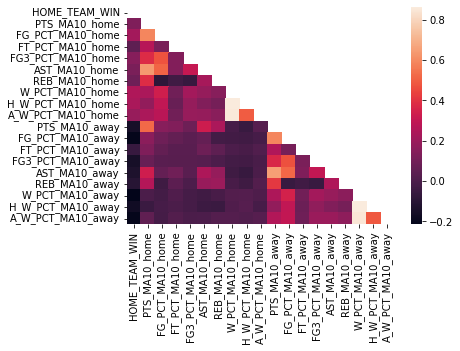

In [22]:
# Keep only stats for data exploration (features and label)
numerics = list(final_game_stats_ma.select_dtypes(include = ['int64', 'float64'])
                .drop(['GAME_ID', 'SEASON', 'TEAM_ID_home', 'TEAM_ID_away'], axis = 1))

corr = final_game_stats_ma[numerics].corr()
heatmap = sns.heatmap(corr, mask = np.triu(np.ones_like(corr, dtype = bool)))
heatmap

We proceed to divide our dataset into features and label, which will be useful for exploring the features individually and to train our models later on.

In [23]:
# Divide data set between features and label and get rid of unrelated categorical variables
label = final_game_stats_ma['HOME_TEAM_WIN']

features = final_game_stats_ma.drop(['GAME_DATE_EST',	'GAME_ID',	'SEASON',	'TEAM_ID_home',	'TEAM_home', 
                                     'TEAM_ID_away', 'TEAM_away', 'HOME_TEAM_WIN'], axis = 1)

Exploring our feature variables...

In [24]:
# Taking a look at the stats for feature variables
np.round(features.describe(), 2)

,PTS_MA10_home,FG_PCT_MA10_home,FT_PCT_MA10_home,FG3_PCT_MA10_home,AST_MA10_home,REB_MA10_home,W_PCT_MA10_home,H_W_PCT_MA10_home,A_W_PCT_MA10_home,PTS_MA10_away,FG_PCT_MA10_away,FT_PCT_MA10_away,FG3_PCT_MA10_away,AST_MA10_away,REB_MA10_away,W_PCT_MA10_away,H_W_PCT_MA10_away,A_W_PCT_MA10_away
count,24270.00,24270.00,24270.00,24270.00,24270.00,24270.00,24270.00,24270.00,24270.00,24270.00,24270.00,24270.00,24270.00,24270.00,24270.00,24270.00,24270.00,24270.00
mean,101.72,0.46,0.76,0.35,22.13,42.66,0.51,0.60,0.42,101.60,0.45,0.76,0.35,22.02,42.64,0.51,0.60,0.42
std,7.77,0.02,0.04,0.04,2.72,2.95,0.17,0.20,0.19,7.92,0.02,0.04,0.04,2.72,2.94,0.17,0.20,0.19
min,66.50,0.27,0.52,0.11,14.00,32.50,0.00,0.00,0.00,56.00,0.28,0.56,0.08,10.00,29.00,0.00,0.00,0.00
25%,96.10,0.44,0.73,0.33,20.20,40.70,0.39,0.46,0.29,95.90,0.44,0.73,0.33,20.10,40.70,0.40,0.47,0.28
50%,101.20,0.46,0.76,0.35,22.00,42.60,0.52,0.61,0.42,101.00,0.45,0.76,0.35,21.80,42.50,0.52,0.61,0.42
75%,106.90,0.47,0.79,0.38,23.90,44.60,0.63,0.74,0.56,106.90,0.47,0.79,0.38,23.70,44.60,0.63,0.74,0.56
max,129.90,0.54,1.00,0.51,34.40,56.00,1.00,1.00,1.00,131.10,0.55,0.94,0.60,34.10,54.40,1.00,1.00,1.00


Plotting the distribution of our feature variables to assess whether rebalancing or scaling our data is needed. 

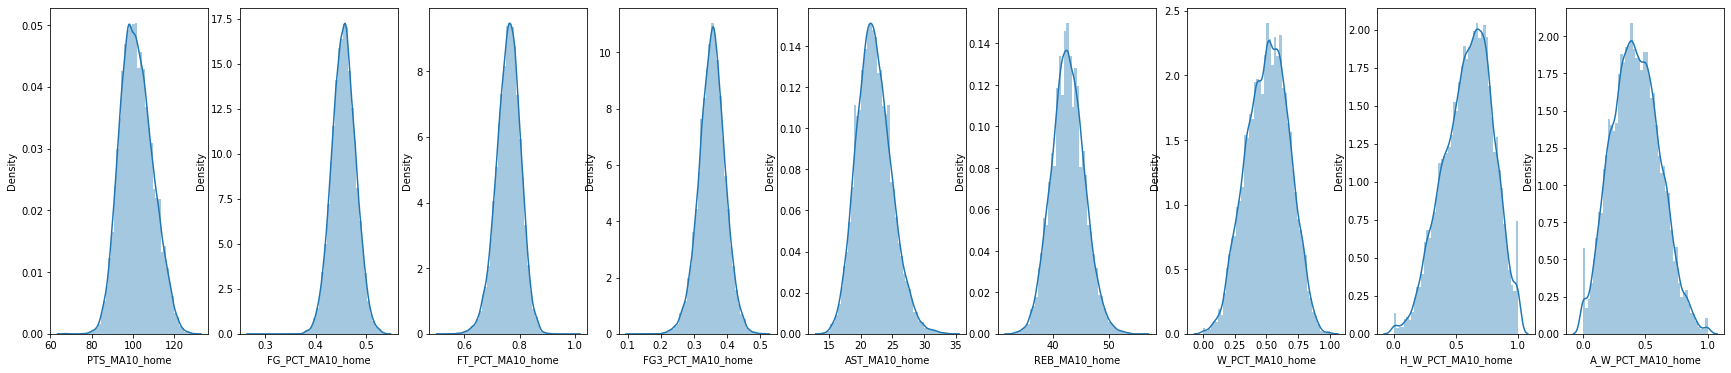

In [25]:
fig, axs = plt.subplots(ncols=9, figsize=(30,6))
sns.distplot(final_game_stats_ma['PTS_MA10_home'], ax=axs[0]);
sns.distplot(final_game_stats_ma['FG_PCT_MA10_home'], ax=axs[1]);
sns.distplot(final_game_stats_ma['FT_PCT_MA10_home'], ax=axs[2]);
sns.distplot(final_game_stats_ma['FG3_PCT_MA10_home'], ax=axs[3]);
sns.distplot(final_game_stats_ma['AST_MA10_home'], ax=axs[4]);
sns.distplot(final_game_stats_ma['REB_MA10_home'], ax=axs[5]);
sns.distplot(final_game_stats_ma['W_PCT_MA10_home'], ax=axs[6]);
sns.distplot(final_game_stats_ma['H_W_PCT_MA10_home'], ax=axs[7]);
sns.distplot(final_game_stats_ma['A_W_PCT_MA10_home'], ax=axs[8]);

We then plot scoring percentage stats against win percentages to determine the relationship between the variables and their relative importance.

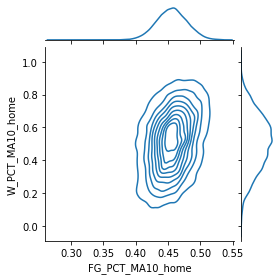

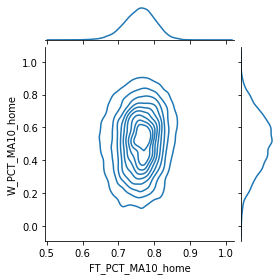

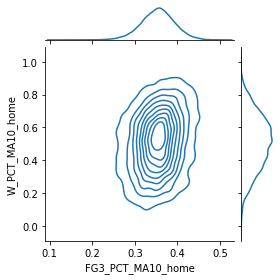

In [26]:
# Explore relationships between scoring percentages and win percentages
sns.jointplot('FG_PCT_MA10_home', 'W_PCT_MA10_home', data=final_game_stats_ma, kind='kde', height=4);
sns.jointplot('FT_PCT_MA10_home', 'W_PCT_MA10_home', data=final_game_stats_ma, kind='kde', height=4);
sns.jointplot('FG3_PCT_MA10_home', 'W_PCT_MA10_home', data=final_game_stats_ma, kind='kde', height=4);

# Part 4: Modeling

## 4.1. Train-Test Split

As with any of the machine learning models that we explored this semester, our data must be split into training sets and testing sets. We used the standard split of 80/20 so that our training data has a sufficient amount of instances to be trained on. 

In [27]:
from sklearn.model_selection import train_test_split

# Create test and train sets (80/20 split)
x_train, x_test, y_train, y_test = train_test_split(features, label, test_size = 0.2)

## 4.2. Random Forest Classifier Model

The first model that we decided to run was a Random Forest model since it allows us to perform binary classification and it incorporates the concept of ensembling to further refine our predictions. Before exploring the hyperparameters, we chose to run a naive version of the model to give us an idea of how accurate our moving average features were in predicting home team outcomes.

In [28]:
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth = None, random_state = 1018)
rf.fit(x_train, y_train)
y_pred_rf = rf.predict(x_test)

In [29]:
# Print accuracy vs test set 
print(metrics.accuracy_score(y_test, y_pred_rf))

0.6837659662134322


Solely setting an arbitrary random_state, the Random Forest model predicted home team outcomes with a 68.6% accuracy level! This was exciting as it proved our model was accurate with little evidence of overfitting. 

Text(0, 0.5, 'Features')

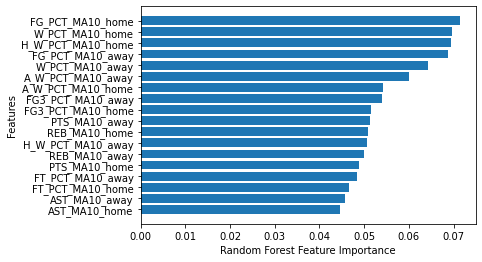

In [30]:
from pprint import pprint
from matplotlib import pyplot as plt

# Plotting the importance of each feature in our model
rf.feature_importances_
sorted_id = rf.feature_importances_.argsort()
plt.barh(features.columns[sorted_id], rf.feature_importances_[sorted_id])
plt.xlabel("Random Forest Feature Importance")
plt.ylabel("Features")

Baed on this output, we were able to predict the outcome of games in our test sample with ~68% accuracy which is quite accurate given the variability in game outcomes. 

Let's try tuning the hyperparameters usiing cross-validation to see if we can induce a model that is even more accurate. 

In [31]:
# Check parameters of our RF
pprint(rf.get_params())
rf.get_params().keys()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1018,
 'verbose': 0,
 'warm_start': False}


dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

We wll adjust bootstrap, max depth, max_features and n_estimators in this step of our exploration by using RandomizedSearchCV 

In [32]:
# *Runtime warning: this cell takes a long time to run, output parameters from this cell can be found below*

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

bootstrap = [True, False] # Sampling with or without replacement
max_depth = [10, 20, 40] # Controlling for the maximum number of levels in our forest
max_features = ['auto', 'sqrt'] # Reducing the number of features considered per split, could help reduce overfitting
n_estimators = [100, 200, 300] # Controlling for the maximum number of splits in our random forest
min_samples_split = [2, 5, 10] # Controlling for the amount of splits and will also likely reduce the number of total splits

parameter_grid = {'bootstrap': bootstrap,
                  'max_depth': max_depth,
                  'max_features': max_features,
                  'n_estimators': n_estimators,
                  'min_samples_split': min_samples_split}

# Now that our grid is defined we can use RandomizedSearchCV to search for the best fitting model given each combination of the parameters described
rf = RandomForestClassifier()
rf_search = RandomizedSearchCV(estimator = rf, param_distributions = parameter_grid, n_iter = 100, cv = 3,
                               n_jobs = -1, random_state = 1018)

rf_search.fit(x_train, y_train)


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 40],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300]},
                   random_state=1018)

Output best parameters obtained from RandomizedSearchCV

In [33]:
rf_search.best_params_

{'n_estimators': 100,
 'min_samples_split': 5,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': False}

Fit and train the model again using the new parameters and assess whether it improves prediction accuracy

In [34]:
# Run Random Forest again with best parameters
rf_best = RandomForestClassifier(n_estimators = 100, max_depth = 10, min_samples_split = 10, random_state = 1018)
rf_best.fit(x_train, y_train)
y_pred_rf_best = rf_best.predict(x_test)

# Print accuracy vs. test set
print(metrics.accuracy_score(y_test, y_pred_rf_best))

0.6938607334157396


Running the random forest with the best parameters found by the RandomizedSearchCV slightly improves accuracy to ~69%

## 4.3. Logistic Regression Model 

Following the satisfactory accuracy level obtained from our tuned Random Forest model, we will run a Logistic Regression model, which adequately fits our binary classification task, in a similar fashion as above to complement our previous findings. 

We start by running the Logistic Regression model with the default parameters

In [35]:
from sklearn.linear_model import LogisticRegression 
from sklearn import metrics

# Initial model with default parameters
lr = LogisticRegression(random_state = 1018)
lr.fit(x_train, y_train)

y_pred_lr = lr.predict(x_test)

# Print accuracy score
print(metrics.accuracy_score(y_test, y_pred_lr))

0.6804697156983931


Although the accuracy obtained by the basic model is meaningful in the area of sports analytics, we will output the parameters of the model to further explore how we can refine it to improve its accuracy

In [36]:
# Check parameters of our LR
pprint(lr.get_params())
lr.get_params().keys()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 1018,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

As shown in the previous section, it is often possible to refine the model by tuning its hyperparameters. To do so, we run a RandomizedSearchCV to identify the best parameters for our Logistic Regression. 

In [37]:
# Running RandomizedSearchCV with a custom parameter grid to find best parameters for our LR
from sklearn.model_selection import RandomizedSearchCV

# Defining parameters
penalty = ['l1', 'l2', 'elasticnet', 'none'] # Lasso, Ridge, Elastic Net, No penalty 
solver = ['lbfgs', 'liblinear', 'saga']
max_iter = [50, 100, 250, 500]
C = [0.25, 0.5, 1.0, 1.5, 2]


# Create the parameter grid
param_grid = {
    'penalty': penalty, 
    'solver': solver, 
    'max_iter':max_iter, 
    'C':C
}

# Now that our grid is defined we can use RandomizedSearchCV to search for the best fitting model given each combination of the parameters described
lr = LogisticRegression()
lr_search = RandomizedSearchCV(estimator = lr, param_distributions = param_grid, n_iter = 100, cv = 3,
                               n_jobs = -1, random_state = 1018)

lr_search.fit(x_train, y_train)

RandomizedSearchCV(cv=3, estimator=LogisticRegression(), n_iter=100, n_jobs=-1,
                   param_distributions={'C': [0.25, 0.5, 1.0, 1.5, 2],
                                        'max_iter': [50, 100, 250, 500],
                                        'penalty': ['l1', 'l2', 'elasticnet',
                                                    'none'],
                                        'solver': ['lbfgs', 'liblinear',
                                                   'saga']},
                   random_state=1018)

In [38]:
lr_search.best_params_

{'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 50, 'C': 1.0}

The best parameters above suggest a Lasso regression as the best fit for our data

In [39]:
# Run Logistic Regression again with best parameters
lr_best = LogisticRegression(penalty = 'l1', C = 0.5, solver = 'liblinear', max_iter = 50, random_state = 1018)
lr_best.fit(x_train, y_train)
y_pred_lr_best = lr_best.predict(x_test)

# Print accuracy vs. test set
print(metrics.accuracy_score(y_test, y_pred_lr_best))

0.688504326328801


Running our Logistic Regression with the best parameters found by the RandomizedSearchCV increased accuracy to ~69%

## 4.4. Naive Bayes Model

The underlying assumption of the Naive Bayes’ Model is that the input features are independent of one another. This is an unrealistic assumption, no matter the data set, but it is something that we acknowledge. We believe that our features are still appropriate to be used in this setting. 

We followed a very simple process using the sk.learn naive bayes package.


In [40]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
y_pred_nb = gnb.fit(x_train, y_train).predict(x_test)

print('Accuracy Score:', metrics.accuracy_score(y_test, y_pred_nb))
print(y_pred_nb)

Accuracy Score: 0.6790276060980635
[0 1 1 ... 1 0 1]


## 4.5. Comparing Model Outcomes: Confusion Matrices


As shown in the previous sections, the models performed better with the custom hyperparameters found by the Randomized Search. Comparing our models' accuracy, we can assert that the Random Forest model performed the best, with an accuracy of 69.26%, followed closely by the Logistic Regression model, with an accuracy of 69.08%. In third place came our Naive Bayes model, both in accuracy (67.45%) and complexity, but still reflected a satisfactory level of accuracy in the context of sports analytics.

Below we plot the confusion matrices from the predictions from each of these three models compared to the test set to visualize the number of false positives and false negatives

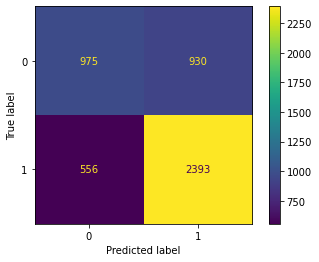

In [41]:
from sklearn.metrics import ConfusionMatrixDisplay

# Random Forest 
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf_best)

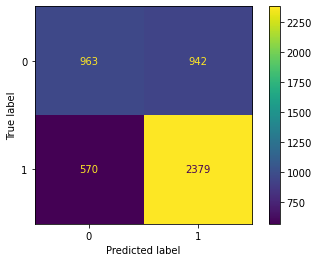

In [42]:
# Logistic Regression
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr_best)

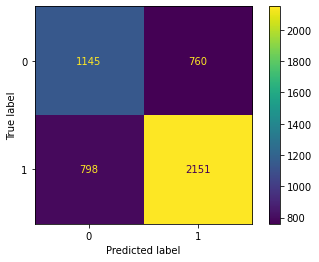

In [43]:
# Naive Bayes
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_nb)

# Part 5: Description of Challenges / Obstacles Faced

The first challenge that we faced was deciding how we could best leverage our original raw data set to achieve our goal. All of the data we had originally was presented in a game by game basis. Inherently, this would cause our subsequent models to be more naïve in that it failed to include other variables that affect game by game performance by only considering single instances. Any sports fan would know that sometimes a teams performance is best reflected by the state of the team at that point and time, whether it be an increase or decrease in chemistry, a star-player not playing, or any other of the moving factors that affect team performance in any given game. This is what motivated us to decide on calculating moving averages for each of our original features to use in our data exploration throughout this project. 
By using moving averages, one can better understand how a team is performing at any given point in the season while mitigating the risk of a single “off-game” or player injury from skewing the data as an outlier. Overall, by using moving averages we were able to ensure that our features took a more wholistic approach in assessing team performance over ten-game stretches without diluting the value that the raw data provided us with in the first place. 

The second, and more difficult, challenge that we faced was putting our new feature idea into effect. After spending much time brainstorming, we developed a function to achieve our goal to produce these 10-day moving averages. The problem that we faced was that we did not know how to account for the inclusion of both home and away performances for each team in our average as their TEAM_ID appeared in both the Home Team and Away Team columns. In our first attempt, we defined a function that called a “for” loop to extract the distinct home and away team ID’s using a Team ID list as reference along with the metric in question. After each team’s total performances with respect to this metric were extracted into home and away data frames, we performed a merge and sorted the instances by date. After this process was completed for each team, we tried to concatenate the current team moving average stats to the rest of the teams already calculated in the temp data frame. Lastly, we made a copy of team_game_stats and merged our temporary data frame with the existing columns, adding the _MA10 column corresponding to home and away teams. To our dismay, this did not work as it immediately overwhelmed the allocated RAM in our Colab session. We needed to find another way, and we did.

 Below we will attach an image of our original code to show our thought process during the early stages of this step:


 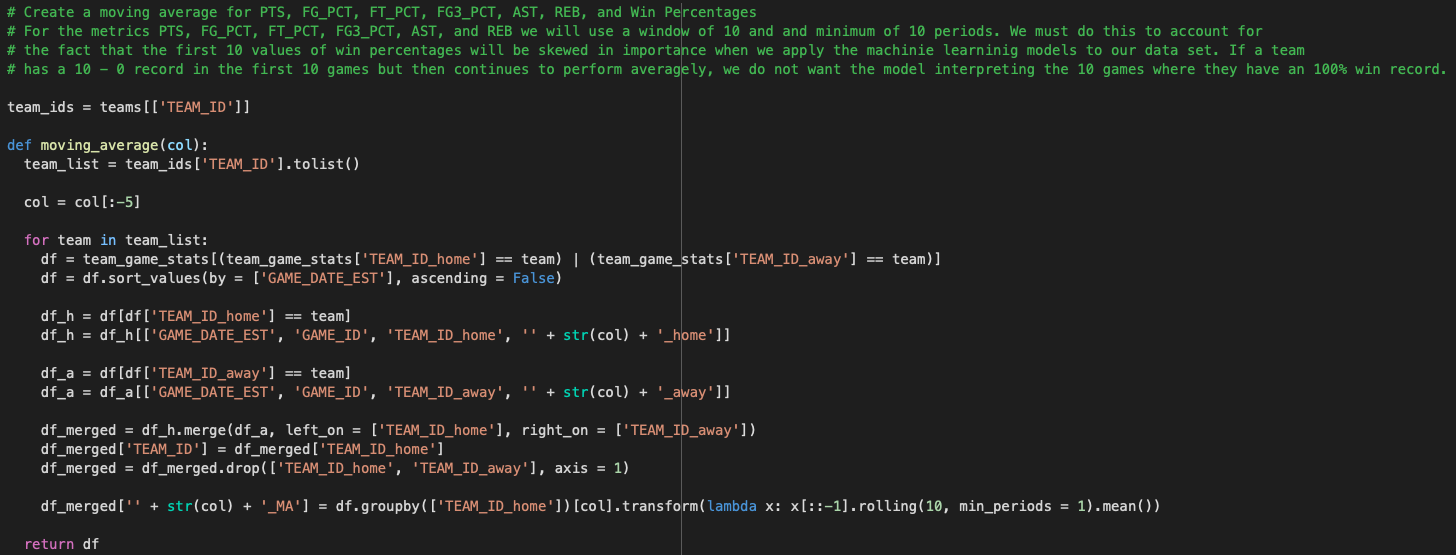

# Part 6: Potential Next Steps / Future Direction 

Overall, we were quite happy with the consistent success our models exhibited as each model was within the 67-69% accuracy range, with our tuned random forest model being the most accurate. We were excited to see that the best published projects that had a similar objective to ours were able to predict with about 75% accuracy. It was both a fun and engaging learning experience to have been able to construct models with such accuracy solely utilizing the skills that we garnered over this past semester under the instruction of both Professor Ives and our TA’s (Thank you!). Moreover, Iván and I are looking forward to using our model recreationally the next time we are having trouble deciding which team is going to win on any given night. However, despite our successes, there is always room for improvement. 

One next step that we would see ourselves going in is exploring other features to include in our model. Currently our models only include moving average game statistics; however, it would be interesting to see if there would be an effective way to include performance of key players, such as your Steph Curry’s and LeBron’s into the model to better predict the performance of each team. From being basketball fans ourselves, it is clear that most teams have key players who can single-handedly effect the outcome of any given game and we believe that including these statistics could make for slightly more accurate models. 

Another step would be to explore more models in our analyses. This includes, but is not limited to, convolutional networks and SGD classifiers. However, we were very pleased with the result of our tuned Random Forest model that proved to be 70% accurate against our testing data, despite the fact that this model was by far the most computationally expensive. 

We hope that you enjoyed our project and we look forward to using these useful skills in the future, however that may be. 
